## Scrapping the tweets between 5th of December - 11st of December

Uncoment below line to re-scrap

In [103]:
# import twint
# import nest_asyncio

# nest_asyncio.apply()

# c = twint.Config()
# c.Username = "collegemenfess"
# c.Since = "2022-12-05"
# c.Until = "2022-12-11"
# c.Store_csv = True
# c.Output = "collegemenfess.csv"
# c.Limit = 5000
# c.Pandas = True

# twint.run.Search(c)

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from gensim.models import Word2Vec
# import MultinomialNB
from sklearn.naive_bayes import MultinomialNB
# import accuracy_score
from sklearn.metrics import accuracy_score
# import TfidfTransformer
from sklearn.feature_extraction.text import TfidfTransformer
# import LogisticRegression
from sklearn.linear_model import LogisticRegression

In [105]:
# load negatif and positif words from assets/negatif.txt and assets/positif.txt
# and store it in negatif and positif list
negatif = []
positif = []

with open('assets/negatif.txt', 'r') as f:
    for line in f:
        negatif.append(line.strip())

with open('assets/positif.txt', 'r') as f:
    for line in f:
        positif.append(line.strip())
        

In [106]:
# remove duplicate words in negatif and positif list
negatif = list(set(negatif))
positif = list(set(positif))


In [107]:
# load data from csv file
df = pd.read_csv('data/collegemenfess.csv')


In [108]:
# pick only tweet column
df = df[['tweet']]
df['real_tweet'] = df['tweet']
df.head()

,tweet,real_tweet
0,[cm] smt 5 mending ikut studi independen dulu ...,[cm] smt 5 mending ikut studi independen dulu ...
1,[cm] di kampus kalian mahasiswa s1 wajib publi...,[cm] di kampus kalian mahasiswa s1 wajib publi...
2,[cm] Bisa gk yh tugas UAS ini ngerjain dirinya...,[cm] Bisa gk yh tugas UAS ini ngerjain dirinya...
3,[CM] Dosen praktikum aku ngasih ini waktu pert...,[CM] Dosen praktikum aku ngasih ini waktu pert...
4,[cm] Alhamdulilah masih bisa hidup walaupun di...,[cm] Alhamdulilah masih bisa hidup walaupun di...


In [149]:
# import slang word from assets/slang.json
slang = pd.read_json('assets/slang.json', typ='series')
slang = slang.to_dict()


In [110]:
# add slang2.txt to slang
with open('assets/slang2.txt', 'r') as f:
    for line in f:
        line = line.strip().split(';')
        slang[line[0]] = line[1]


In [111]:
# function to convert slang word to formal word
def slang_to_formal(text):
    text = text.split()
    new_text = []
    for word in text:
        if word in slang:
            new_text.append(slang[word])
        else:
            new_text.append(word)
    return " ".join(new_text)



In [112]:
# convert slang word to formal word
df['tweet'] = df['tweet'].apply(lambda x: slang_to_formal(x))

In [113]:
df.head()

,tweet,real_tweet
0,[cm] semester 5 lebih baik ikut studi independ...,[cm] smt 5 mending ikut studi independen dulu ...
1,[cm] di kampus kalian mahasiswa s1 wajib publi...,[cm] di kampus kalian mahasiswa s1 wajib publi...
2,[cm] Bisa tidak iya tugas UAS ini mengerjakan ...,[cm] Bisa gk yh tugas UAS ini ngerjain dirinya...
3,[CM] Dosen praktikum saya kasih ini waktu pert...,[CM] Dosen praktikum aku ngasih ini waktu pert...
4,[cm] Alhamdulilah masih bisa hidup walaupun di...,[cm] Alhamdulilah masih bisa hidup walaupun di...


In [114]:
# acronym word from assets/acronym.txt to dictionary
acronym = {}
with open('assets/acronym.txt', 'r') as f:
    for line in f:
        key, value = line.strip().split('=')
        acronym[key] = value



In [115]:
# function to convert acronym word to formal word
def acronym_to_formal(text):
    text = text.split()
    new_text = []
    for word in text:
        if word in acronym:
            new_text.append(acronym[word])
        else:
            new_text.append(word)
    return " ".join(new_text)



In [116]:
# convert acronym word to formal word
df['tweet'] = df['tweet'].apply(lambda x: acronym_to_formal(x))

df.head()

,tweet,real_tweet
0,[cm] semester 5 lebih baik ikut studi independ...,[cm] smt 5 mending ikut studi independen dulu ...
1,[cm] di kampus kalian mahasiswa s1 wajib publi...,[cm] di kampus kalian mahasiswa s1 wajib publi...
2,[cm] Bisa tidak iya tugas UAS ini mengerjakan ...,[cm] Bisa gk yh tugas UAS ini ngerjain dirinya...
3,[CM] Dosen praktikum saya kasih ini waktu pert...,[CM] Dosen praktikum aku ngasih ini waktu pert...
4,[cm] Alhamdulilah masih bisa hidup walaupun di...,[cm] Alhamdulilah masih bisa hidup walaupun di...


In [117]:
import re
def cleanTxt(text):
    text = re.sub(r'\[cm\]|\[CM\]|\[Cm\]|\[cM\]', '', text)
    text = re.sub(r'@\w+|#\w+', '', text) #Removing @mentions
    text = re.sub('#', '', text) # Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('\w+:\/\/\S+', '', text) # Removing hyperlink
    text = re.sub('[^a-zA-Z]', ' ', text)
    # lower case
    text = text.lower()
    return text

In [118]:
# clean the tweet column
df['tweet'] = df['tweet'].apply(cleanTxt)
df.head()

,tweet,real_tweet
0,semester lebih baik ikut studi independen d...,[cm] smt 5 mending ikut studi independen dulu ...
1,di kampus kalian mahasiswa s wajib publish j...,[cm] di kampus kalian mahasiswa s1 wajib publi...
2,bisa tidak iya tugas uas ini mengerjakan diri...,[cm] Bisa gk yh tugas UAS ini ngerjain dirinya...
3,dosen praktikum saya kasih ini waktu pertemua...,[CM] Dosen praktikum aku ngasih ini waktu pert...
4,alhamdulilah masih bisa hidup walaupun dikasi...,[cm] Alhamdulilah masih bisa hidup walaupun di...


In [119]:
# stemming the tweet using Sastrawi 
def stemSentence(sentence):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    output   = stemmer.stem(sentence)
    return output

df['tweet'] = df['tweet'].apply(stemSentence)


In [120]:
# remove stopword using Sastrawi
def removeStopWords(sentence):
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    output = stopword.remove(sentence)
    return output

df['tweet'] = df['tweet'].apply(removeStopWords)

In [121]:
df.head()

,tweet,real_tweet
0,semester studi independen magang yaa semester ...,[cm] smt 5 mending ikut studi independen dulu ...
1,kampus mahasiswa wajib publish jurnal indeks s...,[cm] di kampus kalian mahasiswa s1 wajib publi...
2,iya tugas uas manja bantu kerjain,[cm] Bisa gk yh tugas UAS ini ngerjain dirinya...
3,dosen praktikum kasih waktu temu kelas haru bg...,[CM] Dosen praktikum aku ngasih ini waktu pert...
4,alhamdulilah hidup kasi include kos kuliah jak...,[cm] Alhamdulilah masih bisa hidup walaupun di...


In [122]:
# tokenize the tweet column and store it in unigram column
df['unigram'] = df['tweet'].apply(word_tokenize)


In [123]:
# classify the tweet using negatif and positif words
def classify(text):
    score = 0
    for word in text:
        if word in positif:
            score += 1
        elif word in negatif:
            score -= 1
    return score

df['score'] = df['unigram'].apply(classify)
df.head()

,tweet,real_tweet,unigram,score
0,semester studi independen magang yaa semester ...,[cm] smt 5 mending ikut studi independen dulu ...,"[semester, studi, independen, magang, yaa, sem...",0
1,kampus mahasiswa wajib publish jurnal indeks s...,[cm] di kampus kalian mahasiswa s1 wajib publi...,"[kampus, mahasiswa, wajib, publish, jurnal, in...",0
2,iya tugas uas manja bantu kerjain,[cm] Bisa gk yh tugas UAS ini ngerjain dirinya...,"[iya, tugas, uas, manja, bantu, kerjain]",2
3,dosen praktikum kasih waktu temu kelas haru bg...,[CM] Dosen praktikum aku ngasih ini waktu pert...,"[dosen, praktikum, kasih, waktu, temu, kelas, ...",2
4,alhamdulilah hidup kasi include kos kuliah jak...,[cm] Alhamdulilah masih bisa hidup walaupun di...,"[alhamdulilah, hidup, kasi, include, kos, kuli...",1


In [124]:
# label the tweet based on actual_score
def labelTweet(score):
    if score > 0:
        return 'positif'
    elif score < 0:
        return 'negatif'
    else:
        return 'netral'

df['label'] = df['score'].apply(labelTweet)
df.head()

,tweet,real_tweet,unigram,score,label
0,semester studi independen magang yaa semester ...,[cm] smt 5 mending ikut studi independen dulu ...,"[semester, studi, independen, magang, yaa, sem...",0,netral
1,kampus mahasiswa wajib publish jurnal indeks s...,[cm] di kampus kalian mahasiswa s1 wajib publi...,"[kampus, mahasiswa, wajib, publish, jurnal, in...",0,netral
2,iya tugas uas manja bantu kerjain,[cm] Bisa gk yh tugas UAS ini ngerjain dirinya...,"[iya, tugas, uas, manja, bantu, kerjain]",2,positif
3,dosen praktikum kasih waktu temu kelas haru bg...,[CM] Dosen praktikum aku ngasih ini waktu pert...,"[dosen, praktikum, kasih, waktu, temu, kelas, ...",2,positif
4,alhamdulilah hidup kasi include kos kuliah jak...,[cm] Alhamdulilah masih bisa hidup walaupun di...,"[alhamdulilah, hidup, kasi, include, kos, kuli...",1,positif


In [125]:
# count the label
df['label'].value_counts()

positif    4164
netral     4118
negatif    1578
Name: label, dtype: int64

In [126]:
# save the result to csv
# df.to_csv('result.csv', index=False)


In [127]:
# read the result
df = pd.read_csv('result.csv')
df.head()

,tweet,real_tweet,unigram,bigram,trigram,score,score_bigram,score_trigram,actual_score,label
0,semester studi independen magang yaa semester ...,[cm] smt 5 mending ikut studi independen dulu ...,"['semester', 'studi', 'independen', 'magang', ...","[('semester', 'studi'), ('studi', 'independen'...","[('semester', 'studi', 'independen'), ('studi'...",0,0,0,0,netral
1,kampus mahasiswa wajib publish jurnal indeks s...,[cm] di kampus kalian mahasiswa s1 wajib publi...,"['kampus', 'mahasiswa', 'wajib', 'publish', 'j...","[('kampus', 'mahasiswa'), ('mahasiswa', 'wajib...","[('kampus', 'mahasiswa', 'wajib'), ('mahasiswa...",0,0,0,0,netral
2,iya tugas uas manja bantu kerjain,[cm] Bisa gk yh tugas UAS ini ngerjain dirinya...,"['iya', 'tugas', 'uas', 'manja', 'bantu', 'ker...","[('iya', 'tugas'), ('tugas', 'uas'), ('uas', '...","[('iya', 'tugas', 'uas'), ('tugas', 'uas', 'ma...",2,4,5,5,positif
3,dosen praktikum kasih waktu temu kelas haru bg...,[CM] Dosen praktikum aku ngasih ini waktu pert...,"['dosen', 'praktikum', 'kasih', 'waktu', 'temu...","[('dosen', 'praktikum'), ('praktikum', 'kasih'...","[('dosen', 'praktikum', 'kasih'), ('praktikum'...",2,3,4,4,positif
4,alhamdulilah hidup kasi include kos kuliah jak...,[cm] Alhamdulilah masih bisa hidup walaupun di...,"['alhamdulilah', 'hidup', 'kasi', 'include', '...","[('alhamdulilah', 'hidup'), ('hidup', 'kasi'),...","[('alhamdulilah', 'hidup', 'kasi'), ('hidup', ...",1,2,2,2,positif


In [128]:
# label to number
df['label'] = df['label'].map({'positif': 1, 'negatif': 0, 'netral': 2})
df.head()

,tweet,real_tweet,unigram,bigram,trigram,score,score_bigram,score_trigram,actual_score,label
0,semester studi independen magang yaa semester ...,[cm] smt 5 mending ikut studi independen dulu ...,"['semester', 'studi', 'independen', 'magang', ...","[('semester', 'studi'), ('studi', 'independen'...","[('semester', 'studi', 'independen'), ('studi'...",0,0,0,0,2
1,kampus mahasiswa wajib publish jurnal indeks s...,[cm] di kampus kalian mahasiswa s1 wajib publi...,"['kampus', 'mahasiswa', 'wajib', 'publish', 'j...","[('kampus', 'mahasiswa'), ('mahasiswa', 'wajib...","[('kampus', 'mahasiswa', 'wajib'), ('mahasiswa...",0,0,0,0,2
2,iya tugas uas manja bantu kerjain,[cm] Bisa gk yh tugas UAS ini ngerjain dirinya...,"['iya', 'tugas', 'uas', 'manja', 'bantu', 'ker...","[('iya', 'tugas'), ('tugas', 'uas'), ('uas', '...","[('iya', 'tugas', 'uas'), ('tugas', 'uas', 'ma...",2,4,5,5,1
3,dosen praktikum kasih waktu temu kelas haru bg...,[CM] Dosen praktikum aku ngasih ini waktu pert...,"['dosen', 'praktikum', 'kasih', 'waktu', 'temu...","[('dosen', 'praktikum'), ('praktikum', 'kasih'...","[('dosen', 'praktikum', 'kasih'), ('praktikum'...",2,3,4,4,1
4,alhamdulilah hidup kasi include kos kuliah jak...,[cm] Alhamdulilah masih bisa hidup walaupun di...,"['alhamdulilah', 'hidup', 'kasi', 'include', '...","[('alhamdulilah', 'hidup'), ('hidup', 'kasi'),...","[('alhamdulilah', 'hidup', 'kasi'), ('hidup', ...",1,2,2,2,1


In [129]:
# select score, score_bigram, score_trigram and actual_score as feature
X = df[['score']]
y = df['label']

In [130]:
# split the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# predict the test data
y_pred = model.predict(X_test)

# get the accuracy
print('Accuracy: ', accuracy_score(y_test, y_pred))

# get the confusion matrix
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred))

Accuracy:  0.9594320486815415
Confusion Matrix:  [[318   0  20]
 [  0 820  35]
 [  6  19 754]]


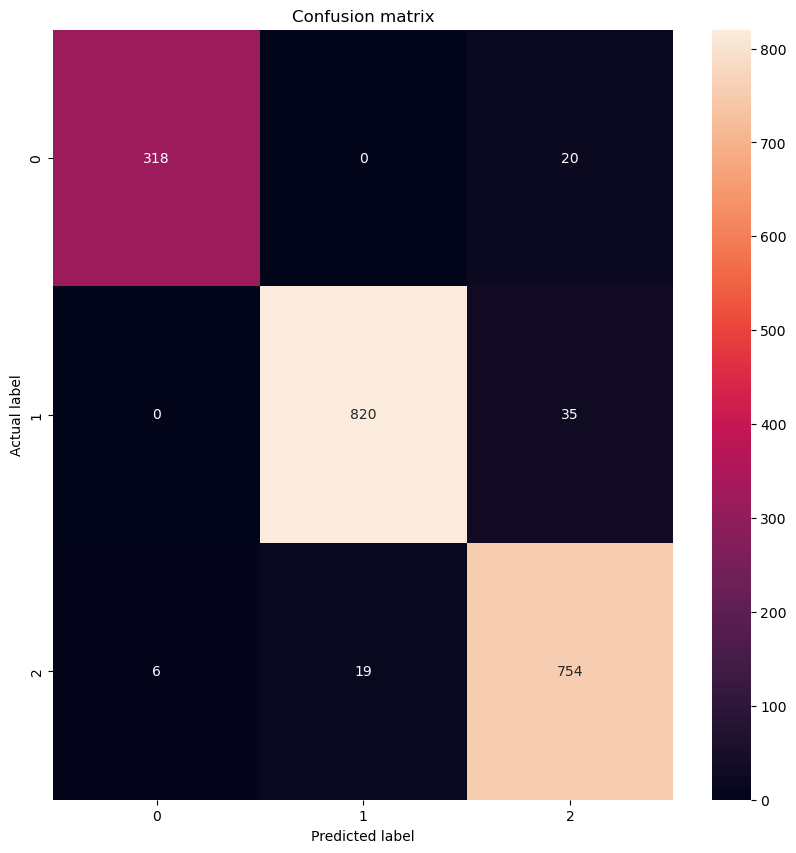

In [131]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [132]:
import twint
import nest_asyncio

nest_asyncio.apply()

# from collegemenfess get 500 latest tweet
c = twint.Config()
c.Username = "collegemenfess"
c.Limit = 500
c.Store_csv = True
c.Output = "test.csv"
twint.run.Search(c)


1608507696822747138 2022-12-29 23:58:14 +0700 <collegemenfess> Punya thread list pertanyaan sempro nggaa. Atau Dari kalian aja dehh gpp. Aku msh smt 5 bsk mo simulasi sempro. Ndredegg bgtttt 😭 [cm]
1608507358464069634 2022-12-29 23:56:53 +0700 <collegemenfess> [cm] krn aku liat banyak pertanyaan seputar skripsi, sini aku bikinin lapaknya wkwkkw  yuk yg mau nanya perskripsian dipersilakan disini. yg mau jawab bisa qrt
1608507341653307393 2022-12-29 23:56:49 +0700 <collegemenfess> [cm] guys kalian ada yg pake app productivity kyk notion gitu2 ga? Kalo iya, kalian pake apa dan kenapa?
1608505492304986114 2022-12-29 23:49:28 +0700 <collegemenfess> [CM] guys klian yang gaa ikut organisasi dan mau mulai magang gitu, isi cv nya yang pengalaman gimana?? Aku bingung isinya. Thanks yang udah jawab
1608505298301648896 2022-12-29 23:48:42 +0700 <collegemenfess> Guys saran laptop untuk jurusan teknik industri dong? Kira2 spek apa aja yg dibutuhkan ya sekalian rekomendasi yaa mksh [cm]
1608505248758

In [133]:
# func to preprocess the tweet
def preprocessing(df):
    df = df[['tweet']]
    df = df.dropna()
    df['tweet'] = df['tweet'].apply(cleanTxt)
    df['tweet'] = df['tweet'].apply(lambda x: slang_to_formal(x))
    df['tweet'] = df['tweet'].apply(lambda x: acronym_to_formal(x))
    df['tweet'] = df['tweet'].apply(stemSentence)
    df['tweet'] = df['tweet'].apply(removeStopWords)
    df['unigram'] = df['tweet'].apply(word_tokenize)
    df['score'] = df['unigram'].apply(classify)
    df['label'] = df['score'].apply(labelTweet)
    df['label'] = df['label'].map({'positif': 1, 'negatif': 0, 'netral': 2})
    return df

In [134]:
# predict the tweet from test.csv
test = pd.read_csv('test.csv')
test.head()
test.shape


(1000, 36)

In [135]:
# preprocess the test data
test = preprocessing(test)

In [136]:
# test data to get precision, recall, f1-score, and support and accuracy and confusion matrix
X_test = test['score']

y_test = test['label']

# reshape the data
X_test = X_test.values.reshape(-1, 1)


# predict the test data
y_pred = model.predict(X_test)

# get the accuracy
print('Accuracy: ', accuracy_score(y_test, y_pred))

# get the confusion matrix
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred))



Accuracy:  1.0
Confusion Matrix:  [[128   0   0]
 [  0 476   0]
 [  0   0 396]]


/Users/akhmadramadani/Documents/TF/miniconda3/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


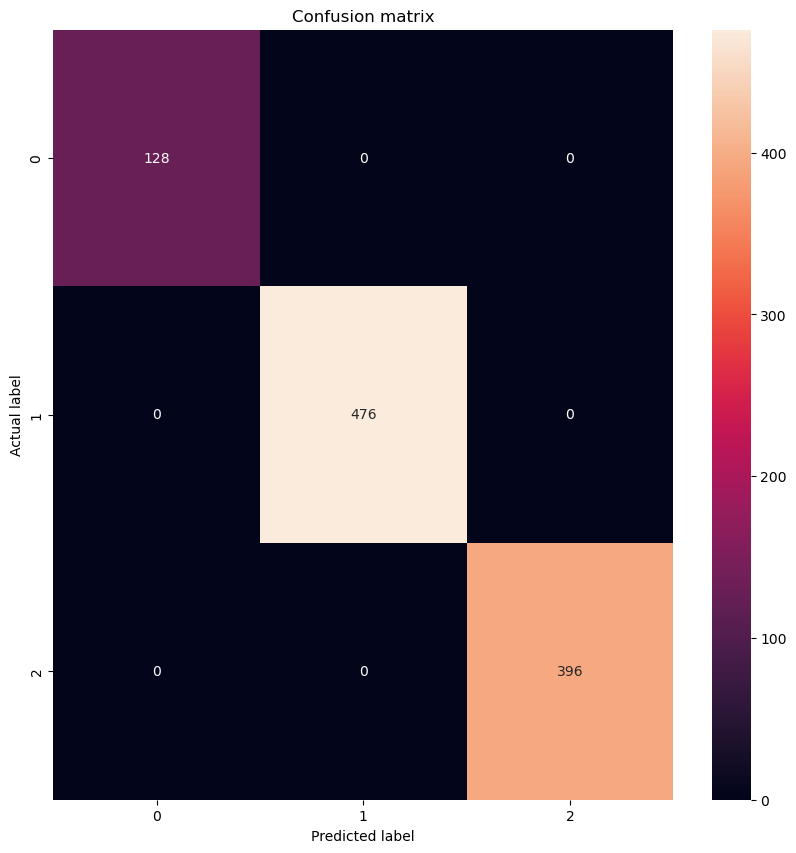

In [137]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [138]:
# save the model
import pickle
pickle.dump(model, open('model.pkl', 'wb'))


In [146]:
# load the model
model = pickle.load(open('model.pkl', 'rb'))


In [151]:

# predict the tweet
def predictTweet(tweet):
    tweet = cleanTxt(tweet)
    tweet = slang_to_formal(tweet)
    tweet = acronym_to_formal(tweet)
    print('Tweet Baku: ', tweet)
    tweet = stemSentence(tweet)
    tweet = removeStopWords(tweet)
    unigram = word_tokenize(tweet)
    score = classify(unigram)
    label = labelTweet(score)
    print('Preprocessed Tweet: ', tweet)
    print('Label: ', label)
    print('Unigram: ', unigram)
    print('Score Unigram: ', score)
    
    return label
